In [164]:
import pandas as pd
import json
from globals import BASE_DIR
import os
import copy
import numpy as np
import matplotlib.pyplot as plt
import math
from postprocess_baseline_top_k import dataset_metadata
from evaluation_metrics import ndcg, calculate_arp_poplift, evaluation_user_group_means, jensen_shannon
import pingouin as pg

top_k_eval = 10

dataset = "yelp"
valid_popularity = "item_pop"
recommendation_dirpart = "recommendations"

In [165]:
def process_top_k_json(input_file, output_file, k=10):
    """
    Process top-k recommendations from a JSON file, keeping only the item IDs for each user.
    """
    os.makedirs(os.path.dirname(output_file), exist_ok=True)
    
    try:
        with open(input_file, "r") as infile:
            data = json.load(infile)

        top_k_result = {}
        for user_id, recommendations in data.items():
            if recommendations and isinstance(recommendations[0], dict):
                item_ids = recommendations[0]["item_id"][:k]
                top_k_result[user_id] = item_ids

        with open(output_file, "w") as outfile:
            json.dump(top_k_result, outfile, indent=4)
        print(f"Processed file saved to: {output_file}")
    
    except Exception as e:
        print(f"Error processing {input_file}: {e}")

In [166]:
def create_model_directories(dataset, data, base_dir, recommendation_dirpart):
    """
    Create output directories
    """
    model_directories = {}
    methods = ["baseline", "cp", "cp_min_js", "upd"]

    def recommender_dir_combiner(dataset, modelpart, method):
        return f"{base_dir}{dataset}_dataset/{recommendation_dirpart}/{modelpart}/{method + '/'}top_k_recommendations.json"

    for result in data:
        model_name = result["model"]
        model_directories[model_name] = {}
        
        for method in methods:
            model_directories[model_name][method] = recommender_dir_combiner(dataset, result["directory"], method)
    
    return model_directories

def open_ground_truth_user_group(dataset, valid_popularity=valid_popularity):
    """Perform data splitting and user group creation."""

    train_data = pd.read_csv(f"{BASE_DIR}{dataset}_dataset/processed_data_recbole/{dataset}_sample.train.inter", sep="\t")
    test_data = pd.read_csv(f"{BASE_DIR}{dataset}_dataset/processed_data_recbole/{dataset}_sample.test.inter", sep="\t")
    valid_data = pd.read_csv(f"{BASE_DIR}{dataset}_dataset/processed_data_recbole/{dataset}_sample.valid.inter", sep="\t")

    print("Train data, test data and valid data shapes:")
    print(train_data.shape, test_data.shape, valid_data.shape)
    train_data = pd.concat([train_data, valid_data])
    user_group_dir = f"{BASE_DIR}{dataset}_dataset/{dataset}_user_id_popularity.json"
    with open(user_group_dir) as f:
        user_groups = json.load(f)

    user_groups["HighPop"] = user_groups.pop("high")
    user_groups["LowPop"] = user_groups.pop("low")
    user_groups["MedPop"] = user_groups.pop("medium")



    checkin_df = train_data.copy()
    
    # Calculate item popularity
    value_counts = checkin_df["item_id:token"].value_counts().reset_index()
    value_counts.columns = ["item_id:token", "count"]
    value_counts[valid_popularity] = value_counts["count"] / len(value_counts)
    checkin_df = checkin_df.merge(
        value_counts[["item_id:token", valid_popularity]],
        on="item_id:token",
        how="left",
    )
    checkin_df.sort_values(by=valid_popularity, ascending=False, inplace=True)
    item_popularity = checkin_df.drop_duplicates(subset="item_id:token", keep="first")[
        ["item_id:token", valid_popularity]
    ]

    h_group = item_popularity.head(int(len(item_popularity) * 0.2))
    h_group["item_pop_group"] = "h"
    t_group = item_popularity.tail(int(len(item_popularity) * 0.2))
    t_group["item_pop_group"] = "t"
    m_group = item_popularity[
        ~item_popularity["item_id:token"].isin(h_group["item_id:token"]) &
        ~item_popularity["item_id:token"].isin(t_group["item_id:token"])
    ]
    m_group["item_pop_group"] = "m"

    item_popularity = pd.concat([h_group, m_group, t_group])
    item_popularity.sort_values(by=valid_popularity, inplace=True, ascending=False)

    upts = checkin_df.groupby("user_id:token")[valid_popularity].mean().reset_index()
    upts.columns = ["user_id:token", "upts"]
    return train_data, test_data, user_groups, item_popularity, upts


In [167]:
data = dataset_metadata(dataset, recommendation_dirpart)

In [168]:
model_dirs = create_model_directories(dataset, data, BASE_DIR, recommendation_dirpart)

In [169]:
def unstack_recommendations(df):
    """Unstack the recommendations for each user into separate rows."""
    unstacked_df = df.explode(["item_id:token"]).reset_index(drop=True)
    return unstacked_df

In [170]:
def top_k_to_df(recommender_dir, top_k_eval=top_k_eval):
    """ This function reads in a JSOn and returns an unstacked DataFrame with the top-k recommendations for each user."""
    with open(recommender_dir) as f:
        data = json.load(f)
    base_recommendations = []


    for user, items in data.items():
        for item in items:
            base_recommendations.append({
                "user_id:token": user,
                "item_id:token": item
            })

    base_df = pd.DataFrame(base_recommendations)
    base_df = unstack_recommendations(base_df)

    df = base_df.groupby("user_id:token").head(top_k_eval)

    return df


In [171]:
train_data, test_data, user_groups, item_popularity, upts = open_ground_truth_user_group(dataset)
user_groups["All"] = user_groups["HighPop"] + user_groups["MedPop"] + user_groups["LowPop"]

Train data, test data and valid data shapes:
(22282, 3) (7633, 3) (5373, 3)


/var/folders/9q/p0b6nwnd5071040x3849mdvc0000gn/T/ipykernel_93625/3776315740.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  h_group["item_pop_group"] = "h"
/var/folders/9q/p0b6nwnd5071040x3849mdvc0000gn/T/ipykernel_93625/3776315740.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t_group["item_pop_group"] = "t"
/var/folders/9q/p0b6nwnd5071040x3849mdvc0000gn/T/ipykernel_93625/3776315740.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

In [172]:
def create_pop_distributions(data):
    """Create a DataFrame with the distribution of item popularity for different user groups."""
    data = data.merge(item_popularity, on="item_id:token", how="left")
    g1 = data.loc[data["user_id:token"].isin(user_groups["HighPop"])].value_counts("item_pop_group", normalize=True).rename("g1")
    g2 = data.loc[data["user_id:token"].isin(user_groups["MedPop"])].value_counts("item_pop_group", normalize=True).rename("g2")
    g3 = data.loc[data["user_id:token"].isin(user_groups["LowPop"])].value_counts("item_pop_group", normalize=True).rename("g3")
    all = data.value_counts("item_pop_group", normalize=True).rename("all")
    distr_df = pd.DataFrame([g1, g2, g3, all]).fillna(0)
    distr_df.rename(index={"g1":"HighPop", "g2":"MedPop", "g3":"LowPop", "all":"All"}, inplace=True)
    return distr_df


ground_truth_distr = create_pop_distributions(train_data)

In [173]:
ground_truth_distr

item_pop_group,h,m,t
HighPop,0.710990,0.266569,0.022441
MedPop,0.442081,0.499832,0.058087
LowPop,0.290590,0.614717,0.094693
All,0.460676,0.480673,0.058651


In [174]:
def preprocess_distr(distr_df):
    """Preprocess the distribution DataFrame for plotting."""
    #distr_df.rename(index={"g1":"HighPop", "g2":"MedPop", "g3":"LowPop", "all":"All"}, inplace=True) # COMMENT IN FOR CALCULATING RESULTS, COMMENT OUT FOR PLOTTING
    data = distr_df.to_dict()
    result = []
    user_groups = data["h"].keys()

    for group in user_groups:
        h_value = data.get("h", {}).get(group, 0)
        m_value = data.get("m", {}).get(group, 0)
        t_value = data.get("t", {}).get(group, 0)
        
        result.append({
            "user_group": group,
            "h_ratio": h_value,
            "m_ratio": m_value,
            "t_ratio": t_value
        })

    return result


In [175]:
# Function for plotting popularity distribution (no legend inside this function)
def plot_popularity_distribution(ax, distr_df, label):
    """ Plot the popularity distribution of items for different user groups."""
    desired_order = ["LowPop", "MedPop", "HighPop", "All"]
    distr_df = distr_df.reindex(desired_order)
    colors = plt.cm.viridis([0.1, 0.5, 0.9])
    bars = distr_df.plot(kind="bar", stacked=True, ax=ax, color=colors, legend=False, edgecolor="black", linewidth=0, width=0.6)
    if label is not None:
        ax.set_title(f"{label}", fontsize=10)
    ax.set_xlabel("User Groups")
    return distr_df

def plot_line_chart(results, model_name, ax, metric):
    """
    Plot scores (nDCG, ARP, PopLift) as line plots for each user group, comparing methods.
    """
    methods = ["baseline", "cp", "cp_min_js", "upd"]
    user_groups = ["HighPop", "MedPop", "LowPop", "All"]
    group_labels = ["HighPop", "MedPop", "LowPop", "All"]

    metric_values = {
        method: [results[model_name][method][group][f"{metric}"] for group in user_groups]
        for method in methods
    }

    metric_transposed = list(zip(*metric_values.values()))  # Group-wise scores across methods

    # Plot each user group"s metric scores as a line plot
    colors = plt.cm.viridis([0.1, 0.5, 0.9, 0.3])
    for idx, group_label in enumerate(group_labels):
        ax.plot(methods, metric_transposed[idx], marker="o", label=group_label, color=colors[idx])

    ax.set_ylabel(f"{metric.upper()} Score", fontsize=12)
    ax.grid(True)
    ax.tick_params(axis="x", labelsize=16)
    ax.tick_params(axis="y", labelsize=16)




In [176]:
def calculate_t_test_between_user_groups(group_scores):
    """ Calculate t-test for two-sample t-test between low and high groups. 
    Source t-test: https://www.geeksforgeeks.org/how-to-conduct-a-two-sample-t-test-in-python/"""
    
    ttest = {}
    # Conducting two-sample ttest
    result_low_high = pg.ttest(list(group_scores["LowPop"].values()), 
                    list(group_scores["HighPop"].values()),
                    correction=True)
    
    result_low_med = pg.ttest(list(group_scores["LowPop"].values()), 
                    list(group_scores["MedPop"].values()),
                    correction=True)
    
    ttest["low_high"] = float(result_low_high["p-val"])
    ttest["low_medium"] = float(result_low_med["p-val"])

    return ttest


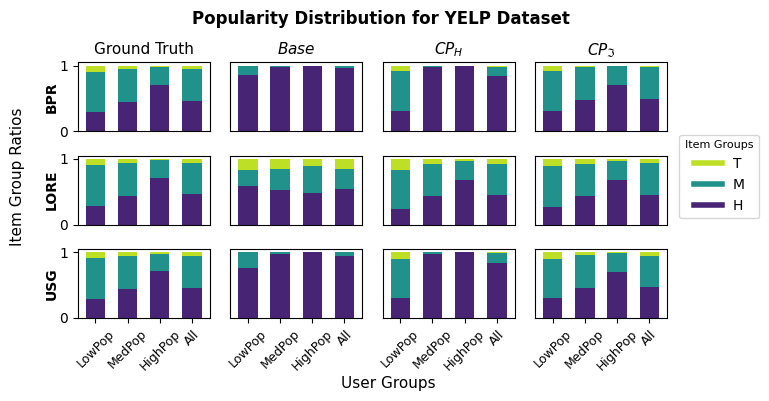

In [177]:
""" Looping through the models and methods to plot the popularity distribution """
fig, axs = plt.subplots(3, 4, figsize=(7, 4.5))  # 3 models x 4 methods
method_names_for_title = ["$Base$", "$CP_H$", "$CP_\Im$"]
model_dirs_plot = copy.deepcopy(model_dirs)
for methods in model_dirs_plot.values():
    methods.pop("upd", None)

for i, (model_name, methods) in enumerate(model_dirs_plot.items()):
    if model_name not in ["SimpleX"]:
        
        ax = axs[i, 0]
        plot_popularity_distribution(ax, ground_truth_distr, None)  # no title here
        if i == 0:
            ax.set_title("Ground Truth", fontsize=11)

        for j, (method_name, json_file) in enumerate(methods.items()):
            df = top_k_to_df(json_file)
            distr_df = create_pop_distributions(df)

            ax = axs[i, j + 1]
            plot_popularity_distribution(ax, distr_df, None)  # no title here
            if i == 0:
                ax.set_title(method_names_for_title[j], fontsize=11)


        axs[i, 0].set_ylabel(model_name, fontsize=10, weight="bold", labelpad=0)

        if i == 3:
                    for k in range(4):
                        axs[i, k].set_xticks(range(4))
                        axs[i, k].set_xlabel("User Groups")
        else:
            for k in range(4):
                axs[i, k].set_xlabel("")

for ax in axs[-1, :]:
    ax.set_xticks(range(4))
    ax.set_xticklabels(["LowPop", "MedPop", "HighPop", "All"], rotation=45, fontsize=9)

for row in axs[:-1, :]:
    for ax in row:
        ax.set_xticks([])

for row in axs:
    for ax in row[1:]:
        ax.set_yticks([])


fig.text(0.58, 0.03, "User Groups", ha="center", fontsize=11)
fig.text(0.04, 0.5, "Item Group Ratios", va="center", rotation="vertical", fontsize=11)

handles = [plt.Line2D([0], [0], color=color, lw=4) for color in plt.cm.viridis([0.9, 0.5, 0.1])]
labels = ["T", "M", "H"]


fig.legend(handles, labels, title="Item Groups", loc="center right", bbox_to_anchor=(1.12, 0.5), ncol=1, title_fontsize=8)
fig.suptitle(f"Popularity Distribution for {dataset.upper()} Dataset", fontsize=12, weight="bold", y=0.87, x=0.57)
plt.tight_layout(rect=[0.05, 0.03, 1, 0.91])
#plt.savefig(f"{BASE_DIR}/{dataset}_dataset/plots/popularity_distribution_paper.png", bbox_inches="tight")


In [178]:
""" Looping through the models and methods to store and process the results """
group_scores_ndcg = {}
group_scores_arp = {}
group_scores_poplift = {}
results = {}
ttest_results = {}

distr_dict_ground_truth = preprocess_distr(ground_truth_distr)

for i, (model_name, methods) in enumerate(model_dirs.items()):
    if model_name not in ["SimpleX"]:
        results[model_name] = {}
        ttest_results[model_name] = {}

        group_scores_ndcg[model_name] = {}
        group_scores_arp[model_name] = {}
        group_scores_poplift[model_name] = {}

        for j, (method_name, json_file) in enumerate(methods.items()):

            ttest_results[model_name][method_name] = {}
  
            df = top_k_to_df(json_file)

            ndcg_scores = ndcg(df, test_data, top_k_eval)
            df_with_item_pop = df.merge(item_popularity, on="item_id:token", how="left")
            arp_scores, poplift_scores = calculate_arp_poplift(df_with_item_pop, item_popularity, upts, valid_popularity)
            distr_df = create_pop_distributions(df)
            distr_dict_recs = preprocess_distr(distr_df)

            


            jsd_group = {}
            for group_gt, group_recs in zip(distr_dict_ground_truth, distr_dict_recs):
                jsd_group[group_gt["user_group"]] = jensen_shannon(group_gt, group_recs)

            group_eval, group_ndcg_scores, group_arp_scores, group_poplift_scores = evaluation_user_group_means(ndcg_scores, arp_scores, poplift_scores, user_groups, df)

            group_scores_ndcg[model_name][method_name] = group_ndcg_scores
            group_scores_arp[model_name][method_name] = group_arp_scores
            group_scores_poplift[model_name][method_name] = group_poplift_scores

            # ttests between low and high / low and medium to check whether LowPop users are disadvantaged
            # ttest_results[model_name][method_name]["ndcg"] = calculate_t_test_between_user_groups(group_ndcg_scores)
            # ttest_results[model_name][method_name]["arp"] = calculate_t_test_between_user_groups(group_arp_scores)
            # ttest_results[model_name][method_name]["poplift"] = calculate_t_test_between_user_groups(group_poplift_scores)
        
            for group_name, jsd_value in jsd_group.items():
                if group_name in group_eval:
                    group_eval[group_name]["js"] = jsd_value
                else:
                    # In case the group exists in jsd_group but not in group_eval
                    group_eval[group_name] = {"js": jsd_value}

            results[model_name][method_name] = group_eval

In [179]:
def t_tests_rq1(metric_scores, model_1="BPR", other_models=["LORE", "USG"]):
    """ Perform t-tests between algorithms/methods to answer RQ1 (Compare Individual Effects of Context-Aware Recommendation and CP to general Baseline)
    Source t-test: https://www.geeksforgeeks.org/how-to-conduct-a-two-sample-t-test-in-python/"""

    ttest_results = {}

    # Compare to other models (LORE, USG)
    for other_model in other_models:
        ttest_results[other_model] = {}
        for group in ["HighPop", "MedPop", "LowPop", "All"]:
            baseline_1 = metric_scores.get(model_1, {}).get("baseline", {}).get(group, {})
            baseline_2 = metric_scores.get(other_model, {}).get("baseline", {}).get(group, {})

            common_users = set(baseline_1.keys()) & set(baseline_2.keys())

            if common_users:
                vals_1 = [baseline_1[u] for u in common_users]
                vals_2 = [baseline_2[u] for u in common_users]

                test = pg.ttest(vals_1, vals_2, paired=True, correction=True)
                delta = np.mean(vals_2) - np.mean(vals_1)

                ttest_results[other_model][group] = {
                    "p_val": float(test["p-val"].values[0]),
                    "delta": float(delta),
                }
            else:
                ttest_results[other_model][group] = {
                    "p_val": None,
                    "delta": None,
                }

    # Compare BPR baseline to its own variants
    for variant in ["cp", "cp_min_js"]:
        ttest_results[variant] = {}
        for group in ["HighPop", "MedPop", "LowPop", "All"]:
            baseline = metric_scores.get(model_1, {}).get("baseline", {}).get(group, {})
            variant_scores = metric_scores.get(model_1, {}).get(variant, {}).get(group, {})

            common_users = set(baseline.keys()) & set(variant_scores.keys())

            if common_users:
                vals_base = [baseline[u] for u in common_users]
                vals_variant = [variant_scores[u] for u in common_users]

                test = pg.ttest(vals_base, vals_variant, paired=True, correction=True)
                delta = np.mean(vals_variant) - np.mean(vals_base)

                ttest_results[variant][group] = {
                    "p_val": float(test["p-val"].values[0]),
                    "delta": float(delta),
                }
            else:
                ttest_results[variant][group] = {
                    "p_val": None,
                    "delta": None,
                }

    return ttest_results


In [180]:
def t_tests_rq2(group_scores):
    """ Perform t-tests between algorithms/methods to answer RQ2 (Compare Combined Effects of Context-Aware Recommendation and CP to the Respective Context-Aware Baseline) """
    ttest_results = {}

    for model_name, methods in group_scores.items():
        ttest_results[model_name] = {}

        for group in ["HighPop", "MedPop", "LowPop", "All"]:
            ttest_results[model_name][group] = {}

            baseline = methods.get("baseline", {}).get(group, {})
            cp = methods.get("cp", {}).get(group, {})
            cp_min_js = methods.get("cp_min_js", {}).get(group, {})

            def clean(d):
                return [float(v) for v in d.values() if isinstance(v, (float, int))]

            baseline_vals = clean(baseline)
            cp_vals = clean(cp)
            cp_min_js_vals = clean(cp_min_js)

            # Compare baseline vs cp
            if baseline_vals and cp_vals:
                result_cp = pg.ttest(baseline_vals, cp_vals, correction=True)
                delta_cp = np.mean(cp_vals) - np.mean(baseline_vals)
                ttest_results[model_name][group]["cp"] = {
                    "p_val": float(result_cp["p-val"].values[0]),
                    "delta": float(delta_cp)
                }
            else:
                ttest_results[model_name][group]["cp"] = {
                    "p_val": None,
                    "delta": None
                }

            # Compare baseline vs cp_min_js
            if baseline_vals and cp_min_js_vals:
                result_cp_min_js = pg.ttest(baseline_vals, cp_min_js_vals, correction=True)
                delta_cp_min_js = np.mean(cp_min_js_vals) - np.mean(baseline_vals)
                ttest_results[model_name][group]["cp_min_js"] = {
                    "p_val": float(result_cp_min_js["p-val"].values[0]),
                    "delta": float(delta_cp_min_js)
                }
            else:
                ttest_results[model_name][group]["cp_min_js"] = {
                    "p_val": None,
                    "delta": None
                }

    return ttest_results


In [181]:
ttest_rq1_ndcg = t_tests_rq1(group_scores_ndcg)
ttest_rq1_arp = t_tests_rq1(group_scores_arp)
ttest_rq1_poplift = t_tests_rq1(group_scores_poplift)

/Users/andreaforster/dev/thesis/preprocessing/prep_venv/lib/python3.11/site-packages/pingouin/parametric.py:248: UserWarning: x and y are equals. Cannot compute T or p-value.
  warnings.warn("x and y are equals. Cannot compute T or p-value.")


In [182]:
ttest_rq2_ndcg = t_tests_rq2(group_scores_ndcg)
ttest_rq2_arp = t_tests_rq2(group_scores_arp)
ttest_rq2_poplift = t_tests_rq2(group_scores_poplift)

In [183]:
def format_results_rq1_with_deltas(
    general_results,
    ttest_rq1_ndcg,
    ttest_rq1_arp,
    ttest_rq1_poplift
):
    
    """ Format the results to put them into a table inlcuding the Delta in Percent and +/-"""
    
    updated_results = copy.deepcopy(general_results["BPR"]["baseline"])

    ttest_dicts = {
        "ndcg": ttest_rq1_ndcg,
        "arp": ttest_rq1_arp,
        "poplift": ttest_rq1_poplift,
    }

    formatted_table = {}

    for group in updated_results:
        formatted_table[group] = {}
        for metric in ["ndcg", "arp", "poplift"]:
            base_val = updated_results[group][metric]
            base_str = f"{base_val:.4f}"
            row = {"BPR": base_str}

            for model in ["LORE", "USG"]:
                delta = ttest_dicts[metric][model][group]["delta"]
                p_val = ttest_dicts[metric][model][group]["p_val"]

                if base_val != 0:
                    percent_delta = (delta / base_val) * 100
                    delta_str = f"{percent_delta:+.2f}%"
                else:
                    delta_str = "N/A"

                if p_val is not None and p_val < 0.05/32:
                    delta_str += " **"

                row[model] = delta_str

            # Now compare BPR(cp) and BPR(cp_min_js) to BPR(baseline)
            for variant in ["cp", "cp_min_js"]:
                delta = ttest_dicts[metric][variant][group]["delta"]
                p_val = ttest_dicts[metric][variant][group]["p_val"]

                # Get the BPR baseline again for consistent comparison
                if base_val != 0:
                    percent_delta = (delta / base_val) * 100
                    delta_str = f"{percent_delta:+.2f}%"
                else:
                    delta_str = "N/A"

                if p_val is not None and p_val < 0.05/32:
                    delta_str += " **"

                row[variant] = delta_str

            formatted_table[group][metric] = row

    return formatted_table


In [184]:
rq1_results = format_results_rq1_with_deltas(results, ttest_rq1_ndcg, ttest_rq1_arp, ttest_rq1_poplift)

In [185]:
def format_results_rq2_with_deltas(
    general_results,
    ttest_rq2_ndcg,
    ttest_rq2_arp,
    ttest_rq2_poplift
):
    """ Format the results to put them into a table inlcuding the Delta in Percent and +/-"""
    updated_results = copy.deepcopy(general_results)
    ttest_dicts = {
        "ndcg": ttest_rq2_ndcg,
        "arp": ttest_rq2_arp,
        "poplift": ttest_rq2_poplift,
    }

    for model in general_results:
        for group in general_results[model]["baseline"]:
            for metric in ["ndcg", "arp", "poplift", "gini", "js"]:
                base_val = general_results[model]["baseline"][group][metric]
                # Format baseline value to 4 decimal places
                base_str = f"{base_val:.4f}"
                updated_results[model]["baseline"][group][metric] = base_str

            for method in ["cp", "cp_min_js"]:
                if method not in general_results[model]:
                    continue
                if group not in general_results[model][method]:
                    continue

                for metric in ["ndcg", "arp", "poplift"]:
                    cur_val = general_results[model][method][group][metric]
                    ttest_dict = ttest_dicts[metric]
                    try:
                        delta = ttest_dict[model][group][method]["delta"]
                        p_val = ttest_dict[model][group][method]["p_val"]
                    except KeyError:
                        continue

                    # Convert delta to percent relative to baseline
                    base_val = float(general_results[model]["baseline"][group][metric])
                    delta_percent = ((cur_val - base_val) / abs(base_val)) * 100 if base_val != 0 else 0
                    delta_str = f"{delta_percent:+.2f}%"
                    if p_val < 0.05/32:       # Bonferroni correction for multiple comparisons
                        delta_str += "**"

                    # Format the current value to 4 decimal places and add the delta
                    formatted = f"{cur_val:.4f} ({delta_str})"
                    updated_results[model][method][group][metric] = formatted

    return updated_results


df_results_rq2 = format_results_rq2_with_deltas(results, ttest_rq2_ndcg, ttest_rq2_arp, ttest_rq2_poplift)


In [186]:
# Saving the data for RQ1
rows = []
for group_name, metrics in rq1_results.items():
    for model in ["BPR", "LORE", "USG", "cp", "cp_min_js"]:
        row = {
            "method": model,
            "user_group": group_name,
            "ndcg": metrics["ndcg"][model],
            "arp": metrics["arp"][model],
            "poplift": metrics["poplift"][model]
        }
        rows.append(row)

df_results_rq1 = pd.DataFrame(rows)
df_results_rq1.to_csv(f"{BASE_DIR}/{dataset}_dataset/evaluation_results_rq1.csv", index=False)


# Saving the data for RQ2
rows = []
for model_name, methods in df_results_rq2.items():
    for method_name, group_eval in methods.items():
        for group_name, metrics in group_eval.items():
            row = {
                "dataset": dataset,
                "model": model_name,
                "method": method_name,
                "user_group": group_name,
                "ndcg": metrics["ndcg"],
                "arp": metrics["arp"],
                "poplift": metrics["poplift"],
                "js": metrics["js"],
                "gini": metrics["gini"],
                
            }
            rows.append(row)

df_results_rq2 = pd.DataFrame(rows)
df_results_rq2.to_csv(f"{BASE_DIR}/{dataset}_dataset/evaluation_results_rq2.csv", index=False)


In [187]:
df_results_rq1

,method,user_group,ndcg,arp,poplift
0,BPR,HighPop,0.0650,0.0093,1.0542
1,LORE,HighPop,-75.53% **,-74.34% **,-145.19% **
2,USG,HighPop,-0.94%,+0.54%,+1.13%
3,cp,HighPop,+0.00%,-0.01%,-0.04%
4,cp_min_js,HighPop,-17.65% **,-18.58% **,-37.78% **
5,BPR,LowPop,0.0192,0.0040,1.7702
6,LORE,LowPop,+126.17% **,-63.60% **,-101.15% **
7,USG,LowPop,+12.65%,-15.61% **,-25.27% **
8,cp,LowPop,+6.94%,-38.46% **,-65.20% **
9,cp_min_js,LowPop,+6.94%,-38.46% **,-65.20% **


In [188]:
df_results_rq2

,dataset,model,method,user_group,ndcg,arp,poplift,js,gini
0,yelp,BPR,baseline,HighPop,0.0650,0.0093,1.0542,0.1591,0.6515
1,yelp,BPR,baseline,LowPop,0.0192,0.0040,1.7702,0.2660,0.6374
2,yelp,BPR,baseline,MedPop,0.0304,0.0079,2.3983,0.3105,0.7481
3,yelp,BPR,baseline,All,0.0350,0.0074,2.0039,0.2545,0.7692
4,yelp,BPR,cp,HighPop,0.0650 (+0.00%),0.0093 (-0.01%),1.0538 (-0.04%),0.156654,0.65147
5,yelp,BPR,cp,LowPop,0.0205 (+6.94%),0.0024 (-38.46%**),0.6161 (-65.20%**),0.000758,0.58902
6,yelp,BPR,cp,MedPop,0.0307 (+1.15%),0.0079 (-0.14%),2.3930 (-0.22%),0.298965,0.753261
7,yelp,BPR,cp,All,0.0355 (+1.36%),0.0071 (-4.21%),1.7698 (-11.68%**),0.12482,0.798218
8,yelp,BPR,cp_min_js,HighPop,0.0535 (-17.65%),0.0076 (-18.58%**),0.6559 (-37.78%**),0.010565,0.713202
9,yelp,BPR,cp_min_js,LowPop,0.0205 (+6.94%),0.0024 (-38.46%**),0.6161 (-65.20%**),0.000758,0.58902


In [189]:
def plot_metric(results, metric, dataset):
    """Plot a line chart with the evolution of each metric"""
    n_models = len(results)
    n_cols = 4
    n_rows = math.ceil(n_models / n_cols)

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
    axs = axs.flatten()  # Flatten to simplify indexing

    for i, (model_name, methods) in enumerate(results.items()):
        plot_line_chart(results, model_name, axs[i], metric)
        axs[i].set_ylabel(model_name, fontsize=14, weight="bold")

    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])  # Remove unused subplots

    fig.suptitle(f"{metric.upper()} Comparison for {dataset}", fontsize=18, weight="bold", x=0.38)

    ndcg_handles = [plt.Line2D([0], [0], color=color, lw=2, marker="o") for color in plt.cm.viridis([0.2, 0.6, 0.8, 0.3])]
    ndcg_labels = ["HighPop", "MedPop", "LowPop", "All"]
    fig.legend(ndcg_handles, ndcg_labels, title="User Groups", loc="upper center", bbox_to_anchor=(0.38, 0.92), ncol=4)

    plt.tight_layout(rect=[0, 0.02, 1, 0.88])  # Reduced bottom space
    plt.savefig(f"{BASE_DIR}{dataset}_dataset/plots/{dataset}_{metric}_comparison.png")



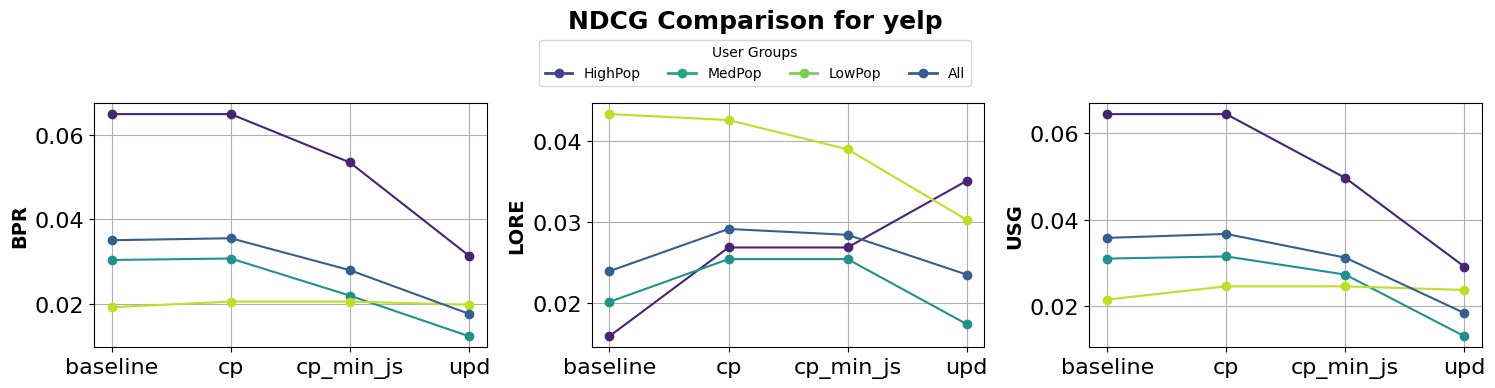

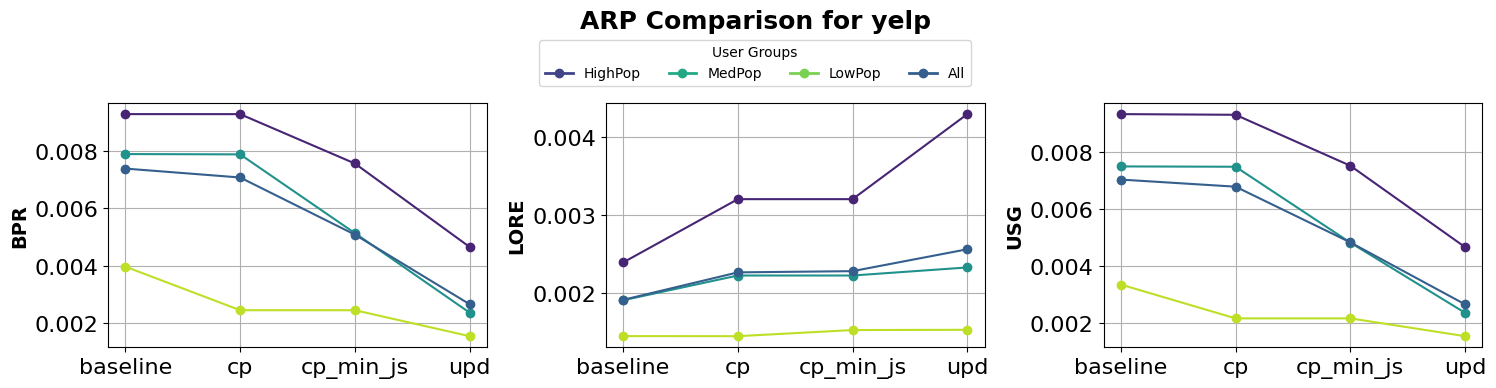

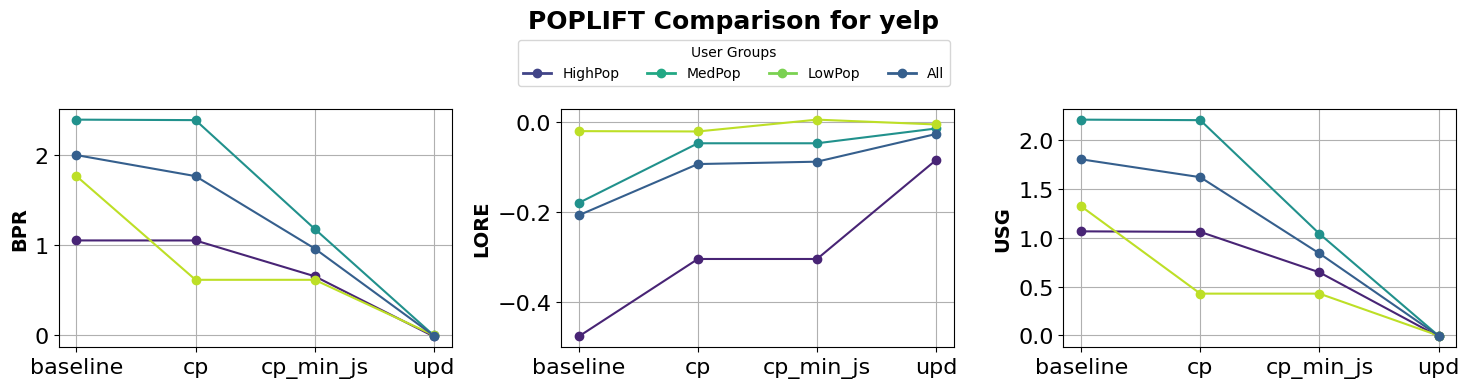

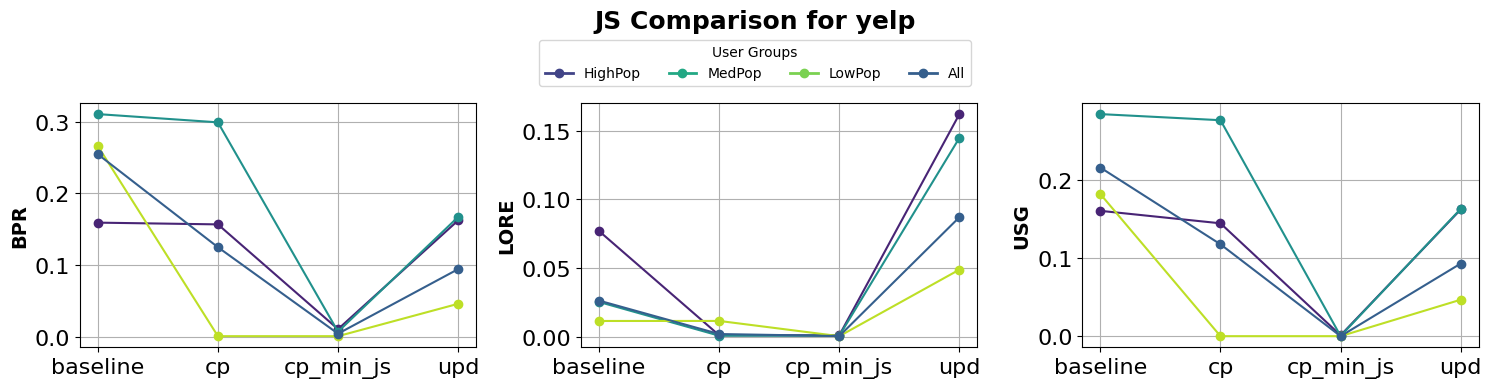

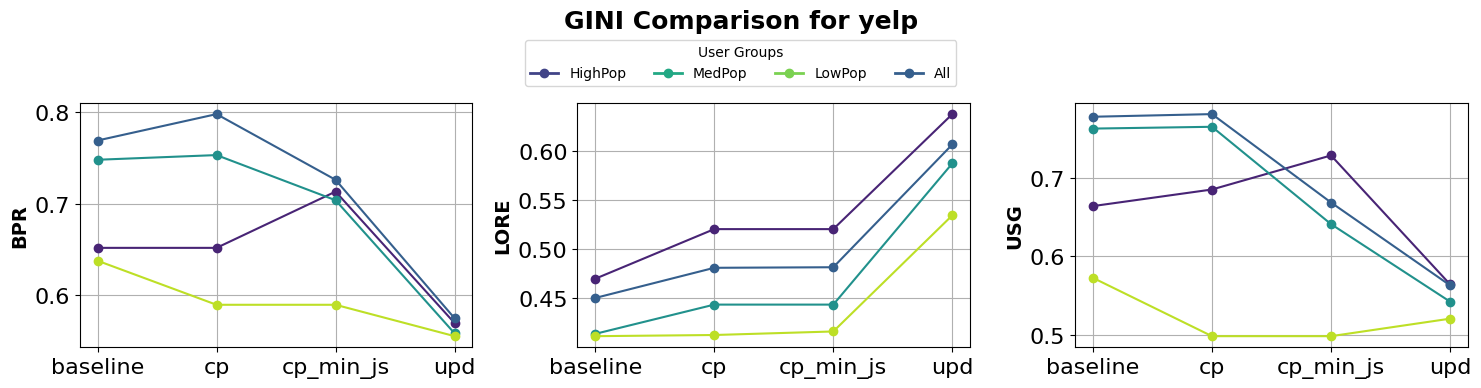

In [190]:

#plot_popularity_distributions(model_dirs, ground_truth_distr, dataset)
plot_metric(results, "ndcg", dataset)
plot_metric(results, "arp", dataset)
plot_metric(results, "poplift", dataset)
plot_metric(results, "js", dataset)
plot_metric(results, "gini", dataset)